# MCMC Processing
This notebook is used to process MCMC data. It takes the chains of parameter values and extracts anaysis products like parameter confidence intervals, energy spectra ranges, and yield curves.

This is a replacement of the on-the-fy processing we were doing in the MCMC_plots notebooks

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *
import R68_spec_tools as spec
import R68_yield as Yield
from tqdm.notebook import tqdm
from matplotlib.pyplot import *

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles
dict_keys(['xx', 'yy', 'ex', 'ey'])


In [3]:
#Turns out we need the helper functions to still be defined since the stored samplers rely on them.
#Don't think it matters if they're exactly the same as what was used, since we don't use them here.
def Fit_helper(theta):
    return calc_log_prob(model='Sor', theta=theta, theta_bounds=((0,1),(0,3e-2),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

In [4]:
#Load the MCMC data
import pickle as pkl

#fname='data/mcmc_Lind_128walk_5kstep_Pois_v1.pkl'
#fname='data/mcmc_Chav_128walk_5kstep_SNorm_v3.pkl'
#fname='data/mcmc_Sor_128walk_5kstep_Pois_v11.pkl'
#fname='data/mcmc_Sor_128walk_5kstep_SNorm_v3.pkl'
fname='data/mcmc_AC_128walk_5kstep_SNorm_v3.pkl'
#fname='data/mcmc_Shexp_128walk_50kstep_Pois_v1.pkl'

############################
basename=os.path.splitext(os.path.basename(fname))[0]

with open(fname,'rb') as file:
    mcmc_data=pkl.load(file)
sampler=mcmc_data['sampler']
guesses=mcmc_data['guesses']
labels=mcmc_data['labels']
model=mcmc_data['Ymodel']

In [5]:
#Make a new object to hold proccessed info
mcmc_data['RQs']={}

In [6]:
print(mcmc_data['t_run']/60,' min')

125.80488595167796  min


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


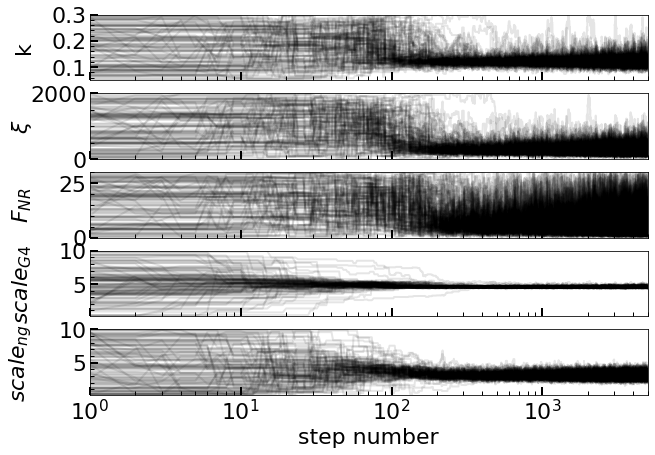

In [7]:
#Look at the chain of parameter values

samples = sampler.get_chain()
ndim = samples.shape[2]

#Show autocorrelation timescales
taus=sampler.get_autocorr_time(tol=0)
mcmc_data['RQs']['taus']=taus

fig, axes = subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], "k", alpha=0.1)
    
    #ax.axvline(taus[i],color='r',linestyle='--')
    
    ax.set_xlim(1, len(samples))
    ax.set_ylim(*(mcmc_data['theta_bounds'][i]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
axes[-1].set_xscale("log");

Text(0, 0.5, 'Counts')

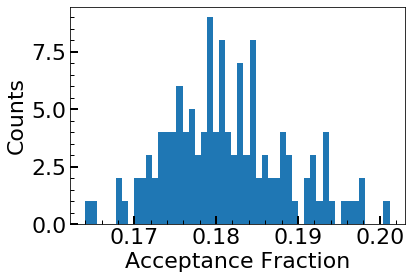

In [8]:
hist(sampler.acceptance_fraction,bins=50);
xlabel('Acceptance Fraction')
ylabel('Counts')

In [9]:
#Get the sample autocorrelation times for each variable and use the largest one
#tol=0 gives an estimate, even if it's bad
print(taus)
maxtau=round(np.max(taus))
mcmc_data['RQs']['maxtau']=maxtau
print(f'Avg tau={np.mean(taus):.1f}, Max tau={maxtau:.1f}')
print(f'Full chain is {samples.shape[0]/maxtau:.1f} tau_max long')

[73.72340217 80.98367644 57.29761554 54.14440219 46.23004518]
Avg tau=62.5, Max tau=81.0
Full chain is 61.7 tau_max long


In [10]:
#Discard a few times tau as burn-in and thin by tau/2
flat_samples = sampler.get_chain(discard=int(2.*maxtau), thin=int(round(maxtau/2.)), flat=True)
print(flat_samples.shape)

(15360, 5)


In [11]:
#Calculate the median and 1-sigma equivalent uncertainties
from IPython.display import display, Math

#Select a particular subset
#ctest=flat_samples[:,2]<30

theta=np.zeros(ndim) #median param values
dtheta=np.zeros((ndim,2)) #1-sigma equivalents
for i in range(ndim):
    pcts = np.percentile(flat_samples[:, i], [16, 50, 84])
    theta[i]=pcts[1]
    dtheta[i] = np.diff(pcts)
    
    txt = r"\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(theta[i], dtheta[i][0], dtheta[i][1], labels[i])
    txt=txt.replace('$','')
    display(Math(txt))

mcmc_data['RQs']['theta']=theta
mcmc_data['RQs']['dtheta']=dtheta

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Calc best fit spectrum
Copied this code right out of the R68_MCMC_MPI file

In [12]:
import R68_load as r68
import R68_spec_tools as spec
#Import likelihood functions
from likelihoods import *

#Set eVee energy binning
Emax=mcmc_data['Emax']
Ebins=mcmc_data['Ebins']
Ebins_ctr=(Ebins[:-1]+Ebins[1:])/2

#Set fit range
E_lim_min=mcmc_data['Efit_min'] #eVee
E_lim_max=mcmc_data['Efit_max'] #eVee
spec_bounds=(np.digitize(E_lim_min,Ebins)-1,np.digitize(E_lim_max,Ebins)-1)
mcmc_data['spec_bounds']=spec_bounds

#Measured spectra background subtraction
#To use the Poisson likelihood, we want to work with PuBe signal counts.
#So we scale the measured background counts by the appropriate livetime and efficiency factors
# then subtract from the measured PuBe data counts
meas=r68.load_measured(cLERate=mcmc_data['cLERate'],verbose=True)
tlive_PuBe=meas['PuBe']['tlive']
N_meas,dN_meas=spec.doBkgSub(meas, Ebins, mcmc_data['Efit_min'], mcmc_data['Efit_max'],\
                             doEffsyst=mcmc_data['doEffsyst'], doLERsyst=mcmc_data['doLERsyst']) #dN returns (high,low)

mcmc_data['RQs']['N_meas']=N_meas
mcmc_data['RQs']['dN_meas']=dN_meas

if mcmc_data['likelihood']=='SNorm':
    #Precalculate split normal likelihood params if we're going to need it
    SNpars=getSNparsArray(N_meas[slice(*spec_bounds)],dN_meas[0][slice(*spec_bounds)],dN_meas[1][slice(*spec_bounds)])
    SNpars=SNpars.T

#Load g4 Simulations
g4=r68.load_G4(load_frac=mcmc_data['g4_load_frac'])
cap=r68.load_simcap(file=mcmc_data['cap_sim_file'], rcapture=mcmc_data['cap_rcapture'], load_frac=mcmc_data['cap_load_frac'])

#Trim events that won't figure into the analysis range
#Trimmed sim data
Eee_er=np.sum(g4['ER']['E'],axis=1)
Evec_er_cut=(Eee_er>10) & (Eee_er<3e3)
Evec_er=g4['ER']['E'][Evec_er_cut]

Eee_nr=np.sum(g4['NR']['E'],axis=1)
Evec_nr_cut=(Eee_nr>10) & (Eee_nr<30e3)
Evec_nr=g4['NR']['E'][Evec_nr_cut]

#Calculate Simulated ER spectrum
#This is independent of other params, so we can do this once and reuse it
N_er = spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_er, Yield=1.0, F=F, scale=1,\
                                   doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'])    

#Import yield models
import R68_yield as Yield
#Initialize Yield model
Y=Yield.Yield('Lind',[0.15])
model=mcmc_data['Ymodel']
Y=Yield.Yield(model,np.zeros(Y.model_npar[model]))

Loading Measured Data...
PuBe events:  (479021,)
Bkg events:  (174510,)


../python/R68_spec_tools.py:62: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2)
../python/R68_spec_tools.py:65: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2)
../python/R68_spec_tools.py:73: RuntimeWarning: divide by zero encountered in true_divide
  cutEff_ratio=eff.cutEffFit(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr)
../python/R68_spec_tools.py:73: RuntimeWarning: invalid value encountered in true_divide
  cutEff_ratio=eff.cutEffFit(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr)
../python/R68_spec_tools.py:74: RuntimeWarning: divide by zero encountered in true_divide
  dcutEff_ratio = cutEff_ratio*np.sqrt( (eff.dcutEffFit(Ebins_ctr)/eff.cutEffFit(Ebins_ctr))**2 +\
../python/R68_spec_tools.py:75: RuntimeWarning: divide by zero encountered in true_divide
  (eff.dcutEffFit_bkg(Ebins_ctr)/eff.cutEffFit_bkg(Ebins_ctr))**2 )
../python/R68_spec_tools.py:78

Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...
1.1  min
Loading ERs...
0.3  min
Loading (n,gamma) Data...
400000


In [13]:
#Again, just taking the same code fro R68_MCMC_MPI
#Commented out some lines that aren't applicable here
nYpar=Y.npars

Y.set_pars(theta[:nYpar])
F_NR=theta[nYpar]
scale_g4=theta[nYpar+1]
scale_ng=theta[nYpar+2]


#Calculate the (log)prior first since we may not need to calculate the likelihood
#lp=lp_flat(theta, theta_bounds)
#if not np.isfinite(lp):
#    return -np.inf

#Special check for pchip yield
#Will fail to solve if the parameters are not ordered.
#This effectively includes some parameter ordering in their priors
if not Y.solve():
    print('return -np.inf')


##########
#Build the spectra
#This includes detector resolution, triggering, and cut efficiency effects
#Does NOT include livetime or write efficiency

#NR
N_nr=spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_nr, Yield=Y, F=F_NR, scale=1, 
                                           doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'])
#(n,gamma)
N_ng=spec.buildAvgSimSpectrum_ee_composite(Ebins=Ebins, Evec=cap['E'], dEvec=cap['dE'], Yield=Y, F=F_NR, scale=1, 
                                           doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'])


#Adjust for livetime and write efficiency
import R68_efficiencies as eff
N_tot_best = (N_nr*scale_g4/g4['NR']['tlive'] + 
          N_er*scale_g4/g4['ER']['tlive'] + 
          N_ng*scale_ng/cap['tlive'])*tlive_PuBe*eff.eff_write
N_nr_best=N_nr*scale_g4/g4['NR']['tlive']*tlive_PuBe*eff.eff_write
N_er_best=N_er*scale_g4/g4['ER']['tlive']*tlive_PuBe*eff.eff_write
N_ng_best=N_ng*scale_ng/cap['tlive']*tlive_PuBe*eff.eff_write


#Calculate the curves
#We'll do this by pulling from the MCMC distribution, making the hists, and finding the 1-sigma equivalent counts in each energy bin
N_nr_plot=list()
N_er_plot=list()
N_ng_plot=list()
N_tot_plot=list()

#Plot command takes an array of spectra (middle, high, low) and plots the middle with shading from high to low
N_nr_plot.append(N_nr_best)
N_er_plot.append(N_er_best)
N_ng_plot.append(N_ng_best)
N_tot_plot.append(N_tot_best)

#Range of curves
nYpar=Y.model_npar[mcmc_data['Ymodel']]
inds = np.random.randint(len(flat_samples), size=100)

N_nrs=list()
N_ers=list()
N_ngs=list()
N_tots=list()

for i,ind in enumerate(tqdm(inds)):
    thetai = flat_samples[ind]
    Y.set_pars(thetai[:nYpar])
    Y.solve()

    nYpar=Y.npars

    Y.set_pars(thetai[:nYpar])
    F_NR=thetai[nYpar]
    scale_g4=thetai[nYpar+1]
    scale_ng=thetai[nYpar+2]


    #Calculate the (log)prior first since we may not need to calculate the likelihood
    #lp=lp_flat(theta, theta_bounds)
    #if not np.isfinite(lp):
    #    return -np.inf

    #Special check for pchip yield
    #Will fail to solve if the parameters are not ordered.
    #This effectively includes some parameter ordering in their priors
    if not Y.solve():
        print('return -np.inf')


    ##########
    #Build the spectra
    #This includes detector resolution, triggering, and cut efficiency effects
    #Does NOT include livetime or write efficiency

    #NR
    N_nr=spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_nr, Yield=Y, F=F_NR, scale=1, 
                                               doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'])
    #(n,gamma)
    N_ng=spec.buildAvgSimSpectrum_ee_composite(Ebins=Ebins, Evec=cap['E'], dEvec=cap['dE'], Yield=Y, F=F_NR, scale=1, 
                                               doDetRes=mcmc_data['doDetRes'], fpeak=mcmc_data['fpeak'])


    #Adjust for livetime and write efficiency
    import R68_efficiencies as eff
    N_tot = (N_nr*scale_g4/g4['NR']['tlive'] + 
              N_er*scale_g4/g4['ER']['tlive'] + 
              N_ng*scale_ng/cap['tlive'])*tlive_PuBe*eff.eff_write


    N_nrs.append(N_nr*scale_g4/g4['NR']['tlive']*tlive_PuBe*eff.eff_write)
    N_ers.append(N_er*scale_g4/g4['ER']['tlive']*tlive_PuBe*eff.eff_write)
    N_ngs.append(N_ng*scale_ng/cap['tlive']*tlive_PuBe*eff.eff_write)
    N_tots.append(N_tot)

N_nrs=np.array(N_nrs)
N_ers=np.array(N_ers)
N_ngs=np.array(N_ngs)
N_tots=np.array(N_tots)

#Best fit spectrum, then upper lim, then lower lim
N_nr_plot.append(np.percentile(N_nrs, 84,axis=0))
N_nr_plot.append(np.percentile(N_nrs, 16,axis=0))

N_er_plot.append(np.percentile(N_ers, 84,axis=0))
N_er_plot.append(np.percentile(N_ers, 16,axis=0))

N_ng_plot.append(np.percentile(N_ngs, 84,axis=0))
N_ng_plot.append(np.percentile(N_ngs, 16,axis=0))

N_tot_plot.append(np.percentile(N_tots, 84,axis=0))
N_tot_plot.append(np.percentile(N_tots, 16,axis=0))


N_nr_plot=np.array(N_nr_plot)
N_er_plot=np.array(N_er_plot)
N_ng_plot=np.array(N_ng_plot)
N_tot_plot=np.array(N_tot_plot)

#Save these curves
mcmc_data['RQs']['N_nr_plot']=N_nr_plot
mcmc_data['RQs']['N_er_plot']=N_er_plot
mcmc_data['RQs']['N_ng_plot']=N_ng_plot
mcmc_data['RQs']['N_tot_plot']=N_tot_plot

In [14]:
#Calculate best fit chisq and Likelihood
 
cFit=slice(*mcmc_data['spec_bounds'])

if mcmc_data['likelihood']=='Norm':
    ll = ll_norm(N_meas[cFit],N_tot_best[cFit])
    #Just use Poisson
    chi=chisq(N_meas[cFit],N_tot_best[cFit],np.sqrt(N_meas[cFit]))
elif mcmc_data['likelihood']=='Pois':
    ll = ll_pois(N_meas[cFit],N_tot_best[cFit])
    #Just use Poisson
    chi=chisq(N_meas[cFit],N_tot_best[cFit],np.sqrt(N_meas[cFit]))
elif mcmc_data['likelihood']=='SNorm':
    SNpars=getSNparsArray(N_meas[cFit],dN_meas[0][cFit],dN_meas[1][cFit])
    SNpars=SNpars.T
    ll = ll_SNorm(N_tot_best[cFit],*SNpars)
    #I guess average high and low sigmas?
    chi=chisq(N_meas[cFit],N_tot_best[cFit],0.5*(dN_meas[0]+dN_meas[1])[cFit])
    
dof=np.diff(mcmc_data['spec_bounds'])[0]-mcmc_data['ndim']
print(f'Chisq/DOF:\t{chi:.4g}/{dof}=\t{chi/dof:.3g}\nlogLikelihood:\t{ll:.4g}')

mcmc_data['RQs']['chisq']=chi
mcmc_data['RQs']['dof']=dof
mcmc_data['RQs']['ll']=ll

Chisq/DOF:	45.55/165=	0.276
logLikelihood:	-953.6


# Yield curve

In [15]:
from scipy.optimize import fsolve
from scipy.special import erf

def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)


#Calc the uncertainty band of yield curves for a set of parameter samples
#
#Er: Array of Er energies to calc over
#Y: Yield model
#flat_samples: trimmed and thinned selection of mcmc chain values
#nsigma: number of sigma width to plot
#nsample: number of examples from flat_samples to use inclaculating the distribution

#Return:
# 3 yield curves in the order (middle, high, low), 
# where middle is the median curve and high,low are the nsigma-equivalent curves

def calcYband(Ers,Y,flat_samples,nsigma=1,nsample=100):
    nYpar=Y.model_npar[mcmc_data['Ymodel']]
    inds = np.random.randint(len(flat_samples), size=nsample)
    Ycurves=np.zeros((nsample,len(Ers)))
    for i,ind in enumerate(inds):
        thetai = flat_samples[ind]
        Y.set_pars(thetai[:nYpar])
        Y.solve()
        Ycurves[i]=Y.calc(Ers).flatten()
    
    #Calc percentiles from sigma
    plow=0.5*(1-0.5*(erf(nsigma/np.sqrt(2))-erf(-nsigma/np.sqrt(2))))
    phi=1-plow
    Ydist=np.percentile(Ycurves,[50,100*phi,100*plow],axis=0)
    return Ydist

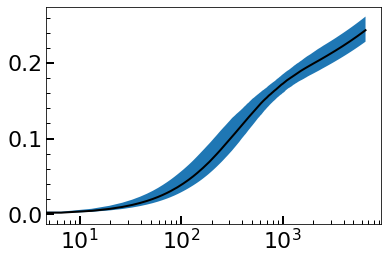

In [16]:
#This work
Y=Yield.Yield('Lind',[0.2])
Y.set_model(mcmc_data['Ymodel'])
nYpar=Y.model_npar[mcmc_data['Ymodel']]
Y.set_pars(theta[:nYpar])
Y.solve()


Er_Ycalc=np.linspace(0,ERtoNR(mcmc_data['Efit_max'],Y,V,eps)[0],1000)
Ydist=calcYband(Er_Ycalc,Y,flat_samples,nsigma=1,nsample=1000)

mcmc_data['RQs']['Ydist']=Ydist
mcmc_data['RQs']['Er_Ycalc']=Er_Ycalc

fill_between(Er_Ycalc,Ydist[1],Ydist[2])
plot(Er_Ycalc,Ydist[0],'k')

xscale('log')

In [17]:
#########################################
######## SAVE IT ALL! ###################
with open(fname,'wb') as file:
    pkl.dump(mcmc_data,file)